In [0]:
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import cv2
import random
import matplotlib.pyplot as plt
import gym
#import universe # register the universe environments
from collections import defaultdict #for Q ie: state Q values store
from collections import namedtuple #for transistions store ie: memory, buffer, ReplayMemory

In [2]:
import atari_py as ap
game_list = ap.list_games()
print(sorted(game_list))

['adventure', 'air_raid', 'alien', 'amidar', 'assault', 'asterix', 'asteroids', 'atlantis', 'bank_heist', 'battle_zone', 'beam_rider', 'berzerk', 'bowling', 'boxing', 'breakout', 'carnival', 'centipede', 'chopper_command', 'crazy_climber', 'defender', 'demon_attack', 'double_dunk', 'elevator_action', 'enduro', 'fishing_derby', 'freeway', 'frostbite', 'gopher', 'gravitar', 'hero', 'ice_hockey', 'jamesbond', 'journey_escape', 'kaboom', 'kangaroo', 'krull', 'kung_fu_master', 'montezuma_revenge', 'ms_pacman', 'name_this_game', 'phoenix', 'pitfall', 'pong', 'pooyan', 'private_eye', 'qbert', 'riverraid', 'road_runner', 'robotank', 'seaquest', 'skiing', 'solaris', 'space_invaders', 'star_gunner', 'tennis', 'time_pilot', 'tutankham', 'up_n_down', 'venture', 'video_pinball', 'wizard_of_wor', 'yars_revenge', 'zaxxon']


In [3]:
!git clone https://github.com/openai/universe.git
!cd universe
!pip install -e .
#!pip install 'gym[atari]'
!pip install universe
import universe # register the universe environments

Cloning into 'universe'...
remote: Enumerating objects: 1476, done.
remote: Total 1476 (delta 0), reused 0 (delta 0), pack-reused 1476
Receiving objects: 100% (1476/1476), 1.58 MiB | 4.23 MiB/s, done.
Resolving deltas: 100% (938/938), done.
ERROR: File "setup.py" not found. Directory cannot be installed in editable mode: /content
     |████████████████████████████████| 143kB 4.9MB/s 
     |████████████████████████████████| 778kB 22.7MB/s 
     |████████████████████████████████| 51kB 19.0MB/s 
     |████████████████████████████████| 737kB 39.8MB/s 
     |████████████████████████████████| 645kB 32.5MB/s 
     |████████████████████████████████| 153kB 34.2MB/s 
     |████████████████████████████████| 3.1MB 32.3MB/s 
     |████████████████████████████████| 194kB 38.6MB/s 
     |████████████████████████████████| 2.3MB 34.9MB/s 
     |████████████████████████████████| 204kB 43.5MB/s 
     |████████████████████████████████| 512kB 44.5MB/s 
     |████████████████████████████████| 174kB 36.8MB/s

In [0]:
#env = gym.make('MontezumaRevengeNoFrameskip-v4') #play env
# env = gym.make('MontezumaRevenge-v0')
# env.reset()
#env.render()

In [0]:
# custom weights initialization
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

# conv helper 
def conv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True, init_zero_weights=False):
    """Creates a convolutional layer, with optional batch normalization.
    """
    layers = []
    conv_layer = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=stride, padding=padding, bias=False)
    if init_zero_weights:
        conv_layer.weight.data = torch.randn(out_channels, in_channels, kernel_size, kernel_size) * 0.001
    layers.append(conv_layer)

    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))
    return nn.Sequential(*layers)

In [0]:
class Meta_Controller(nn.Module):
    # Meta-controller predicts the value of a goal
    def __init__(self, MC_conv_out, MC_hidden_size, MC_number_of_goals, ngpu):
        super(Meta_Controller, self).__init__()
        self.ngpu = ngpu
        # conv(channels_in, channels_out, kernel, stride, padding)
        self.conv1 = conv(1, 32, 8, 4, 0) #all 3 convs set to paper figure 5b Q1 example
        self.conv2 = conv(32, 64, 4, 2, 0)
        self.conv3 = conv(64, 64, 3, 1, 0)
        self.projection = nn.Linear(MC_conv_out, MC_hidden_size) #set to h=512 via paper figure 5b
        self.output = nn.Linear(MC_hidden_size, MC_number_of_goals)
        self.nonLinearity = torch.nn.ReLU()

    def forward(self, x):
        #print("inside Meta_Controller.forward")
        x = self.nonLinearity(self.conv1(x))
        x = self.nonLinearity(self.conv2(x))
        x = self.nonLinearity(self.conv3(x))
        x = x.view(1, -1) # flatten
        x = self.nonLinearity(self.projection(x))
        x = self.output(x)
        return x[0]

class Controller(nn.Module):
    # Controller predicts the value of a action
    def __init__(self, C_conv_out, C_hidden_size, C_number_of_actions, ngpu):
        super(Controller, self).__init__()
        self.ngpu = ngpu
        # conv(channels_in, channels_out, kernel, stride, padding)
        self.conv1 = conv(1, 32, 8, 4, 0) #all 3 convs set to paper figure 5b
        self.conv2 = conv(32, 64, 4, 2, 0)
        self.conv3 = conv(64, 64, 3, 1, 0)
        self.projection = nn.Linear(C_conv_out, C_hidden_size) #set to h=512 via paper figure 5b
        self.output = nn.Linear(C_hidden_size, C_number_of_actions)
        self.nonLinearity = torch.nn.ReLU()

    def forward(self, x):
        #print("inside Controller.forward")
        x = self.nonLinearity(self.conv1(x))
        x = self.nonLinearity(self.conv2(x))
        x = self.nonLinearity(self.conv3(x))
        x = x.view(1, -1) # flatten
        x = self.nonLinearity(self.projection(x))
        x = self.output(x)
        return x[0]

In [0]:
#memory code from AISC RL Workshop
class ReplayMemory(object):
    '''
        A simple memory for storing episodes where each episodes 
        is a names tuple with (state, action, next_state, reward, done)
    '''

    def __init__(self, capacity):
        '''
          Initialize memory of size capacity
          Input: Capacity : int 
                      size of the memory

          output: initialized ReplayMemory object
        '''
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, meta, *args): # meta=True or False to pick storage (MC/C)
        '''
          input *args : list  *args is list for transition 
          [state, action, next_state, reward, done] and add
          transition to memory.
          Returns : None
        '''
        if len(self.memory) < self.capacity:
            self.memory.append(None) #give it space in memory to set
        #self.memory[self.position] = Transition(*args) #original
        if meta:
            self.memory[self.position] = D2(*args)
        else:
            self.memory[self.position] = D1(*args)
        self.position = (self.position + 1) % self.capacity 
        #^ mod makes it loop around once it passed 10k

    def sample(self, batch_size, meta): # meta=True or False to pick storage (MC/C)
        '''
          Randomly sample transitions from memory
          Input batch_size : int
                  numer of transition to sample
          Output:  namedtuple
                    Namedtupe with each field contains a list of data points

        '''
        batch = random.sample(self.memory, batch_size)
        #return Transition(*zip(*batch)) #original
        if meta:
            return D2(*zip(*batch))
        else:
            return D1(*zip(*batch))


    def __len__(self):
        '''
            returns current size of memory
        '''
        return len(self.memory)

In [0]:
class Agent():

    def __init__(self, env, MC_buffer, C_buffer,\
                 learning_rate, gamma,\
                 exploration_param2, exploration_param1,\
                 max_goals_to_try, batch_size, extrinsic_tries_before_eval, conv_stack='stacked'): #conv_stack = stacked' for 4, 1, 84, 84, or 'side_by_side' for 1, 1, 84, 336
        self.new_session = True
        self.env = env
        self.learning_rate = learning_rate
        self.MC_buffer = MC_buffer
        self.C_buffer = C_buffer
        self.gamma = gamma # "discount rate"
        self.ep2 = exploration_param2 #MC, meta-controller
        self.ep1 = exploration_param1 #C, controller
        #self.state = None #input
        self.done = False
        self.terminated = False
        self.max_goals_to_try = max_goals_to_try
        self.num_goals_tried = 0
        self.Q1 = None
        self.Q2 = None
        self.batch_size = batch_size
        self.intrinsic_reward = 0
        self.intrinsic_success_count = 0
        self.intrinsic_total = 0
        self.extrinsic_success_count = 0
        self.total_sessions = 0
        self.eval_tries = extrinsic_tries_before_eval
        self.goals = []
        self.actions = list(range(self.env.action_space.n))
        self.num_actions = 0
        self.session_success = False
        self.session_success_list = []
        self.session_success_list_unique_count = []
        self.ss_count = 0
        self.ml_success = 0 #for middel_ladder threachold for reducing explore
        self.lives = 0
        self.max_steps = 5000
        self.max_score = 400
        self.max_intrinsic_score = 6
        self.score = 0
        self.track_actions = np.zeros(self.env.action_space.n)
        self.track_goals = np.zeros(6)
        # reset memory
        C_buffer.__init__(1000000)
        MC_buffer.__init__(50000)

    def show_state_image(state, conv_stack='stacked'):
        if conv_stack=='stacked':
            observationCheck = state[0].view(84,84).numpy() # 4, 1, 84, 84
        else:
            observationcheck = state[:, :, :, :84].view(84,84).numpy() # 1, 1, 84, 336
        print("check goal (%s) color: "%(goal_name) + str(np.array(observationCheck).shape))
        plt.imshow(np.array(np.squeeze(observationCheck)))
        plt.show()

    def softmax(self, x):
        return (np.exp(x - np.amax(x)) / np.sum(np.exp(x - np.amax(x))))

    def change_pixels(self, state, center_pixel: list, padding: int): #state tensor is size (N, C, W, H)
        staring_row = center_pixel[0] - padding
        starting_column = center_pixel[1] - padding
        side = padding * 2 + 1
        i = staring_row
        while i < staring_row + side:
            j = starting_column
            while j < starting_column + side:
                if i == center_pixel[0] and j == center_pixel[1]:
                    pass
                else:
                    state[0][0][i][j] = 16
                j += 1
            i += 1
        return state, center_pixel
    
    def create_goals(self, state):
        #goal_template = torch.ones_like(state)
        # goal 1 (key): change pixels: center: row: 30, column: 9, padding: 1?
        key = lambda state: self.change_pixels(state, [30, 7], 3)
        # goal 2 (middle-ladder): change pixels: center: row: 35, column: 41, padding: _?
        middle_ladder = lambda state: self.change_pixels(state, [25, 41], 3)
        # goal 3 (left-ladder): change pixels: center: row: 59, column: 17, padding: _?
        left_ladder = lambda state: self.change_pixels(state, [55, 13], 3)
        # goal 4 (right-ladder): change pixels: center: row: 59, column: 71, padding: _?
        right_ladder = lambda state: self.change_pixels(state, [59, 71], 3)
        # goal 5 (left-door): change pixels: center: row: 10, column: 10, padding: _?
        left_door = lambda state: self.change_pixels(state, [12, 14], 3)
        # goal 6 (right-door): change pixels: center: row: 10, column: 76, padding: _?
        right_door = lambda state: self.change_pixels(state, [12, 69], 3)
        self.goals = [key, middle_ladder, left_ladder, right_ladder, left_door, right_door]
        self.goals_names = ['key', 'middle_ladder', 'left_ladder', 'right_ladder', 'left_door', 'right_door']

    def init_Q(self, env): #not actually used atm
        # create Q value store if none
        self.Q1 = defaultdict(lambda: np.zeros(env.action_space.n))
        self.Q2 = defaultdict(lambda: np.zeros(len(goals)))

    def init_session(self):
        # reset state to init
        # self.env = utils.wrap_env(gym.make('MontezumaRevenge-v4'))
        state = self.env.reset()
        self.done = False
        # reset time_step to init
        time_step = 0 #not in use atm
        # create goals
        if not self.goals:
            self.create_goals(state)
        return state, time_step

    # preprocess() from: http://www.pinchofintelligence.com/openai-gym-part-3-playing-space-invaders-deep-reinforcement-learning/
    def preprocess(self, observation):
        observation = cv2.cvtColor(cv2.resize(observation, (84, 110)), cv2.COLOR_BGR2GRAY)
        observation = observation[26:110,:]
        #ret, observation = cv2.threshold(observation,1,255,cv2.THRESH_BINARY)
        ret, observation = cv2.threshold(observation,20,255,cv2.THRESH_TRUNC)
        #ret, observation = cv2.threshold(observation,0,255,cv2.THRESH_TOZERO)
        return np.reshape(observation,(1,84,84))

    def format_state(self, state, next_state=None, test=False, first=False):
        # init starting image state with 3 previous void images states
        if self.new_session:
            state = self.preprocess(state)
            state = torch.from_numpy(state).unsqueeze(dim=0).type('torch.FloatTensor')
            ph_state = torch.zeros_like(state)
            #--for 4, 1, 84, 84--
            if conv_stack=='stacked':
                state = torch.cat((state, ph_state), dim=0)
                state = torch.cat((state, ph_state), dim=0)
                state = torch.cat((state, ph_state), dim=0)
            #--for 1, 1, 84, 336--
            else:
                state = torch.cat((state, ph_state), dim=-1)
                state = torch.cat((state, ph_state), dim=-1)
                state = torch.cat((state, ph_state), dim=-1)
            #some test code from preprocess() source
            if first:
                action0 = 0  # do nothing
                observation0, reward0, terminal, info = self.env.step(action0)
                print("action space: ", env.action_space)
                print("observation space: ", env.observation_space)
                print("reward0: ", reward0)
                print("terminal: ", terminal)
                print("info: ", info)
                print("Before processing: " + str(np.array(observation0).shape))
                plt.imshow(np.array(observation0))
                plt.show()
                observation0 = self.preprocess(observation0)
                print("After processing: " + str(np.array(observation0).shape))
                plt.imshow(np.array(np.squeeze(observation0)))
                plt.show()
                print("new observation space: ", env.observation_space)
                #brain.setInitState(observation0) #test model not used
                #brain.currentState = np.squeeze(brain.currentState) #test model not used
        else: #advance state image set to be 'next state, previous, previous, previous'
            next_state = self.preprocess(next_state)
            next_state = torch.from_numpy(next_state).unsqueeze(dim=0).type('torch.FloatTensor')
            state = self.update_state(state, next_state) #output = 'next state, previous, previous, previous'
        if test: #for viewing state image matricies
            print("state size (shape): ", state.size())
            batch = state
            bottom_label = list(range(0, 83))
            for image in batch:
                for channel in image:
                    for i, grid in enumerate(channel):
                        print("Grid %s: "%(i), grid)
                        print("label  :        ", bottom_label)
                    break #break after 1
            raise NotImplementedError
        
        return state.to(device)
    
    def update_state(self, state, next_state):
        #--for 4, 1, 84, 84--
        if conv_stack=='stacked': #*arg not passed in atm, hard coded
            state[1:] = state[:-1]
            state[0] = next_state
        #--for 1, 1, 84, 336--
        else:
            state[:, :, :, 84:] = state[:, :, :, :252]
            state[:, :, :, :84] = next_state
        return state

    def critic(self, state, action, goal, goal_name):
        #-execute action in env
        #self.env.render(mode='ansi')
        #env.reset()
        next_state, extrinsic_reward, done, info = env.step(action)
        self.max_steps += 1
        #-format next_state
        next_state = self.format_state(state, next_state)
        next_state, goal_pixel = goal(state) # put goal on current state image
        #-check color and goal
        #show_state_image(next_state)
        #-get intrinsic reward
        #if next_state[0][0][goal_pixel[0]][goal_pixel[1]] == 255:
        if next_state[0][0][goal_pixel[0]][goal_pixel[1]] == 20:
            #print("Got the (ง°ل͜°)ง %s!"%(goal_name))
            #--show goal images
            #show_state_image(next_state)
            self.session_success_list.append(goal_name)
            if goal_name == 'key':
                print("!!!!!!!!!!!!!!!!!!!!Got the [̲̅$̲̅(̲̅ ͡° ͜ʖ ͡°̲̅)̲̅$̲̅]  %s  [̲̅$̲̅(̲̅ ͡° ͜ʖ ͡°̲̅)̲̅$̲̅] !!!!!!!!!!!!!!!!!!!!"%(goal_name))
            return extrinsic_reward, 1, next_state, done #intrinsic_reward = 1
        else:
            if info['ale.lives'] < self.lives:
                self.lives -= 1
                return extrinsic_reward, -10, next_state, done #intrinsic_reward = -10 for lost life (not in mentioned in paper)
            else:
                return extrinsic_reward, 0, next_state, done #intrinsic_reward = 0

    def select_direction(self, choices, exploration_param): #select goal, or action, greedy vs explore
        random = np.random.uniform(size=1)[0]
        if random <= exploration_param: #explore
            return np.random.choice(np.arange(len(choices)))
        else: #greedy
            return np.argmax(choices.detach().numpy())

    def train(self):
        first = True
        # if self.Q1 == None:
        #     self.init_Q(env)
        bQn = 0 #count for batch to break for training
        while self.num_goals_tried < self.max_goals_to_try:
            if self.new_session == True:
                # reset session
                state, time_step = self.init_session()
                state = self.format_state(state, first=first, test=False)
                self.new_session = False
                first = False
                self.session_success = False
                self.session_success_list = []
                self.lives = 6
                self.max_steps = 500
                self.score = 0
                self.ss_count = 0
                self.intrinsic_success_count = 0
                self.intrinsic_total = 0
                self.done = False
            Q2_prediction = MC_pred(state) # set Q values for goal at given state
            i_goal = self.select_direction(Q2_prediction, self.ep2) # select goal intex
            goal_name = self.goals_names[i_goal]
            #print("The current goal is: ", goal_name)
            #print("goal is (☞ﾟヮﾟ)☞  %s  ☜(ﾟヮﾟ☜)"%(goal_name))
            goal = self.goals[i_goal] # select goal function
            state_goal, goal_pixel = goal(state) # put goal on current state image
            self.track_goals[i_goal] += 1
            #-show goal
            #show_state_image(state_goal)
            self.intrinsic_reward = 0
            while self.intrinsic_reward == 0 and not self.done or self.max_steps < 500:
                Q1_prediction = C_pred(state_goal) # set Q values for action at given state and goal
                i_action = self.select_direction(Q1_prediction, self.ep1) # select action intex
                action = self.actions[i_action] # select action from list of actions by index
                #self.track_actions[i_action] += 1
                self.num_actions += 1
                extrinsic_reward, self.intrinsic_reward, next_state, self.done = self.critic(state, action, goal, goal_name) #get rewards and state
                self.score += (extrinsic_reward + self.intrinsic_reward)
                #-store transitions
                C_buffer.push(False, state_goal, action, self.intrinsic_reward, next_state) #store controller transition
                MC_buffer.push(True, state, i_goal, extrinsic_reward, next_state) #store meta-controller transition
                #-update state
                state = next_state
                #-manage batch NN update cycle
                bQn += 1
                if bQn % 50000 == 0 and bQn != 0:
                    sample = C_buffer.sample(self.batch_size, False)
                    self.update_Q1(sample.state, sample.action, sample.next_state, sample.reward)
                    # sample = MC_buffer.sample(self.batch_size, True)
                    # self.update_Q2(sample.state, sample.goal, sample.next_state, sample.reward)
                #-track intrinsic reward success and total
                if self.intrinsic_reward > 0:
                    #print("last goal achieved in %s actions!"%(self.num_actions))
                    self.num_actions = 0
                    self.intrinsic_success_count += 1
                    #print("self.intrinsic_success_count: ", self.intrinsic_success_count)
                    self.session_success = True
                    #utils.show_video()
                self.intrinsic_total += 1
                #-track extrinsic reward success
                if extrinsic_reward > 0:
                    self.extrinsic_success_count += 1
            #-track number of goals tried so far
            self.num_goals_tried += 1
            #-when done reset session
            if self.done or self.max_steps == 500:
                #-track total sessions
                self.total_sessions += 1
                #-new session
                self.new_session = True
                print("----done----")
                #print("self.intrinsic_success_count: ", self.intrinsic_success_count)
                #print("self.extrinsic_success_count: ", self.extrinsic_success_count)
                print("self.total_sessions: ", self.total_sessions)
                print("Session ending score: ", self.score)
                #print("Action selection percents: ", self.softmax(self.track_actions))
                print("Goal names: ", self.goals_names)
                print("Goal selection percents: ", self.softmax(self.track_goals))
                self.env.close()
                # utils.show_video()
                if self.session_success:
                    print("Success in this video are: ", self.session_success_list)
                    self.session_success_list_unique_count = []
                    for name in self.session_success_list:
                        if not name in self.session_success_list_unique_count:
                            self.session_success_list_unique_count.append(name)
                        if 'middle_ladder' in self.session_success_list_unique_count:
                            self.ml_success += 1
                    self.ss_count = len(self.session_success_list_unique_count)
                    #stop middle_ladder from reducing explore beyond .6
                    if 'middle_ladder' in self.session_success_list_unique_count and self.ml_success > 40: #for middel_ladder threachold for reducing explore
                        self.ss_count -= 1
                    #utils.show_video()
                if self.ss_count > 0:
                    print("reduce by: ", (.01 * self.ss_count))
                    self.ep1 = self.ep1 - (.01 * self.ss_count)
                if self.ep1 < .1:
                    self.ep1 = .1 #cap minimum exploration at .1
                print("New action exploration is %s"%(self.ep1))
                print("------------")
            if self.num_goals_tried%self.eval_tries == 0:
                sample = MC_buffer.sample(self.batch_size, True)
                self.update_Q2(sample.state, sample.goal, sample.next_state, sample.reward)
                #-how often extrinsic goal was reached
                self.ep2 = self.ep2 - (.01 * self.extrinsic_success_count)
                if self.ep2 < .1:
                    self.ep2 = .1 #cap minimum exploration at .1
                print("New goal exploration is %s"%(self.ep2))
        #env.close()
        #utils.show_video()

    def update_Q1(self, states, actions, next_states, rewards):
        preds = []
        expect = []
        C_pred.zero_grad()
        for i, _ in enumerate(states):
            #C_pred.zero_grad()
            prediction = C_pred(states[i].to(device))
            prediction = prediction[actions[i]]
            preds.append(prediction)
            expectation = C_targ(next_states[i])
            expectation = rewards[i] + (self.gamma * torch.max(expectation, dim=0)[0]) #notice, as long as (gamma^t_prime-t) is relative to the previous state it's gamma^1 = gamma
            expect.append(expectation)
            # loss = F.mse_loss(prediction, expectation.detach())
            # loss.backward()
            # optimizerC.step()
        prediction = torch.stack(preds, 0)
        expectation = torch.stack(expect, 0)
        loss = F.mse_loss(prediction, expectation.detach())
        loss.backward()
        optimizerC.step()

    def update_Q2(self, states, _goals, next_states, rewards):
        preds = []
        expect = []
        C_pred.zero_grad()
        for i, _ in enumerate(states):
            #MC_pred.zero_grad()
            prediction = MC_pred(states[i].to(device))
            prediction = prediction[_goals[i]]
            preds.append(prediction)
            expectation = MC_targ(next_states[i])
            expectation = rewards[i] + (gamma * torch.max(expectation, dim=0)[0]) #notice, as long as (gamma^t_prime-t) is relative to the previous state it's gamma^1 = gamma
            expect.append(expectation)
            # loss = F.mse_loss(prediction, expectation.detach())
            # loss.backward()
            # optimizerMC.step()
        prediction = torch.stack(preds, 0)
        expectation = torch.stack(expect, 0)
        loss = F.mse_loss(prediction, expectation.detach())
        loss.backward()
        optimizerC.step()

In [9]:
!wget -O utils.py https://drive.google.com/uc?id=18arMwKmz1KUpNxxD-pMPDtWSm8I2OG0i
import utils

--2019-10-07 21:20:35--  https://drive.google.com/uc?id=18arMwKmz1KUpNxxD-pMPDtWSm8I2OG0i
Resolving drive.google.com (drive.google.com)... 74.125.20.101, 74.125.20.138, 74.125.20.102, ...
Connecting to drive.google.com (drive.google.com)|74.125.20.101|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-10-0k-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/vhb860mcvnsotai6r250j28tmt22gjt7/1570478400000/12953947379101213852/*/18arMwKmz1KUpNxxD-pMPDtWSm8I2OG0i [following]
--2019-10-07 21:20:36--  https://doc-10-0k-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/vhb860mcvnsotai6r250j28tmt22gjt7/1570478400000/12953947379101213852/*/18arMwKmz1KUpNxxD-pMPDtWSm8I2OG0i
Resolving doc-10-0k-docs.googleusercontent.com (doc-10-0k-docs.googleusercontent.com)... 74.125.195.132, 2607:f8b0:400e:c09::84
Connecting to doc-10-0k-docs.googleusercontent.com (doc-10-0k-docs.googleusercontent.com)|74.125.195

In [0]:
# env = utils.wrap_env(gym.make('MontezumaRevenge-v0'))
# env.reset()
# for _ in range(1000):
#     env.render(mode='ansi')
#     env.step(env.action_space.sample()) # take a random action
# env.close()
# utils.show_video()
# #env.action_space.n
# #env.pos
# #env.reset()

In [0]:
# environment
#env = gym.make('MontezumaRevenge-v4')
env = utils.wrap_env(gym.make('MontezumaRevenge-v4'))
env.reset()

#---memory---
# meta-controller
D2 = namedtuple('D2',
                    ('state', 'goal', 'reward', 'next_state')) #reward = extrinsic reward
# controller
D1 = namedtuple('D1',
                    ('state', 'action', 'reward', 'next_state')) #reward = intrinsic reward

#---params---
batch_size = 512
conv_stack = 'stacked' # 'stacked' or 'side_by_side' but anything other than 'stacker' will trigger 'side_by_side'

# meta-controller dims
if conv_stack=='stacked':
    MC_conv_out = 4 * 64 * 7 * 7 # for 4, 1, 84, 84
else:
    MC_conv_out = 1 * 64 * 7 * 38 # for 1, 1, 84, 336
MC_hidden_size = 512
MC_number_of_goals = 6 #num_of_goals

# controller dims
if conv_stack=='stacked':
    C_conv_out = 4 * 64 * 7 * 7 # for 4, 1, 84, 84
else:
    C_conv_out = 1 * 64 * 7 * 38 # for 1, 1, 84, 336
C_hidden_size = 512
C_number_of_actions = env.action_space.n #num_of_actions

# Agent vars
env = env
MC_buffer = ReplayMemory(1000000)
#MC_buffer = ReplayMemory(50000)
C_buffer = ReplayMemory(50000)
#C_buffer = ReplayMemory(10000)
learning_rate =  0.00025
gamma = .99
exploration_param2 = 1 #start at 1 go to 0.1
exploration_param1 = 1 #start at 1 go to 0.1
num_of_goals = 6 #randomly picked 6 ftm #object_detector.goals.n #pseudo
num_of_actions = env.action_space.n
max_goals_to_try = 2000000
#batch_size = 512
extrinsic_tries_before_eval = batch_size #setting for batch_size ftm

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# Assign models
MC_pred = Meta_Controller(MC_conv_out, MC_hidden_size, MC_number_of_goals, ngpu).to(device)
MC_pred.apply(weights_init)
MC_targ = Meta_Controller(MC_conv_out, MC_hidden_size, MC_number_of_goals, ngpu).to(device)
MC_targ.apply(weights_init)
C_pred = Controller(C_conv_out, C_hidden_size, C_number_of_actions, ngpu).to(device)
C_pred.apply(weights_init)
C_targ = Controller(C_conv_out, C_hidden_size, C_number_of_actions, ngpu).to(device)
C_targ.apply(weights_init)

# Handle multi-gpu if desired
model = None #not Implemented
if (device.type == 'cuda') and (ngpu > 1):
    model = nn.DataParallel(model, list(range(ngpu)))

# Setup Adam optimizers for MC_pred and C_pred, excluded _targ in attempt to hold those constant
optimizerMC = optim.Adam(MC_pred.parameters(), lr=learning_rate, betas=(0.5, 0.999))
optimizerC = optim.Adam(C_pred.parameters(), lr=learning_rate, betas=(0.5, 0.999))

action space:  Discrete(18)
observation space:  Box(210, 160, 3)
reward0:  0.0
terminal:  False
info:  {'ale.lives': 6}
Before processing: (210, 160, 3)


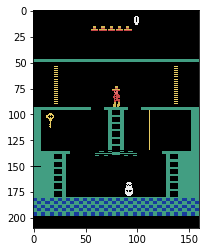

After processing: (1, 84, 84)


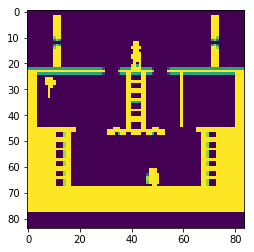

new observation space:  Box(210, 160, 3)
----done----
self.total_sessions:  1
Session ending score:  -58.0
Goal names:  ['key', 'middle_ladder', 'left_ladder', 'right_ladder', 'left_door', 'right_door']
Goal selection percents:  [0.02730045 0.54834411 0.20172453 0.07421031 0.07421031 0.07421031]
Success in this video are:  ['middle_ladder', 'middle_ladder']
reduce by:  0.01
New action exploration is 0.99
------------
----done----
self.total_sessions:  2
Session ending score:  -60.0
Goal names:  ['key', 'middle_ladder', 'left_ladder', 'right_ladder', 'left_door', 'right_door']
Goal selection percents:  [0.00712306 0.14307041 0.3889057  0.01936247 0.05263266 0.3889057 ]
New action exploration is 0.99
------------
----done----
self.total_sessions:  3
Session ending score:  -59.0
Goal names:  ['key', 'middle_ladder', 'left_ladder', 'right_ladder', 'left_door', 'right_door']
Goal selection percents:  [0.00426978 0.23312201 0.08576079 0.01160646 0.03154963 0.63369132]
Success in this video a

In [0]:
#--Agent call--
agent = Agent(env, #environment
      MC_buffer, #MC_buffer
      C_buffer, #C_buffer
      learning_rate, #learning_rate
      gamma, #gamma
      exploration_param1, #exploration_param1
      exploration_param2, #exploration_param2
      max_goals_to_try, #max_goals_to_try
      batch_size, #batch_size
      extrinsic_tries_before_eval) #extrinsic_tries_before_eval

agent.train()

In [0]:
# env = utils.wrap_env(env)
# observation = env.reset()
# total_raward_rnd = 0
# softmax = lambda x: (np.exp(x - np.amax(x))) / np.sum(np.exp(x - np.amax(x)))
# while True:
#     env.render()
#     policy = softmax(agent.C_pred(observation))
#     action = np.random.choice(agent.actions, p=policy)
#     observation, reward, done, info = env.step(action)
#     total_raward_rnd += reward
#     if done: 
#       break;
# print(total_raward_rnd)
# env.close()
# utils.show_video() 